Nombre: José Eyzaguirre

Curso:Machine Learning (b2b-sonda-ds-mayo-2025)


## Carga y exploración inicial de datos
Cargar el dataset desde Kaggle, explorar su estructura, identificar valores faltantes y outliers.


**Reasoning**:
The first step is to load the dataset into a pandas DataFrame. I will use `pd.read_csv` for this purpose and then display the first few rows to understand the structure. After that, I will use `df.info()` to get a summary of the DataFrame and `df.isnull().sum()` to check for missing values. Finally, I will generate descriptive statistics using `df.describe()` to identify potential outliers in numerical columns.



In [2]:
import pandas as pd

# Cargar el conjunto de datos
df = pd.read_csv('insurance.csv')

# Mostrar las primeras filas
print("Primeras 5 filas del DataFrame:")
display(df.head())

# Obtener un resumen de la información del DataFrame
print("\nInformación del DataFrame:")
display(df.info())

# Calcular y mostrar el número de valores faltantes por columna
print("\nValores faltantes por columna:")
display(df.isnull().sum())

# Generar estadísticas descriptivas para columnas numéricas
print("\nEstadísticas descriptivas de columnas numéricas:")
display(df.describe())

Primeras 5 filas del DataFrame:


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520



Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None


Valores faltantes por columna:


,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0



Estadísticas descriptivas de columnas numéricas:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Preprocesamiento de datos

Imputar valores faltantes, codificar variables categóricas y escalar características numéricas.


**Reasoning**:
Identify categorical and numerical columns, apply one-hot encoding to categorical columns and standard scaling to numerical columns, and combine the processed features into a single DataFrame.



In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# Identificar columnas categóricas y numéricas
categorical_features = ['sex', 'smoker', 'region']
numerical_features = ['age', 'bmi', 'children'] # Excluimos 'charges' ya que es la variable objetivo

# Crear transformadores para características numéricas y categóricas
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Crear un transformador de columnas para aplicar diferentes transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Aplicar las transformaciones
processed_data = preprocessor.fit_transform(df)

# Obtener los nombres de las columnas después de la codificación one-hot
categorical_column_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combinar nombres de columnas numéricas y categóricas
all_column_names = numerical_features + list(categorical_column_names)

# Crear un nuevo DataFrame con los datos procesados y los nombres de columna apropiados
processed_df = pd.DataFrame(processed_data, columns=all_column_names)

# Añadir la variable objetivo 'charges' al DataFrame procesado
processed_df['charges'] = df['charges']

# Mostrar las primeras filas del DataFrame procesado
print("Primeras 5 filas del DataFrame procesado:") # Added print statement in Spanish
display(processed_df.head())

Primeras 5 filas del DataFrame procesado:


,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,charges
0,-1.438764,-0.453320,-0.908614,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,16884.92400
1,-1.509965,0.509621,-0.078767,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1725.55230
2,-0.797954,0.383307,1.580926,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,4449.46200
3,-0.441948,-1.305531,-0.908614,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,21984.47061
4,-0.513149,-0.292556,-0.908614,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,3866.85520


## Implementación de modelos de clasificación


Entrenar y evaluar modelos de Regresión Logística, KNN y Árbol de Decisión utilizando validación cruzada.


**Reasoning**:
Import the necessary libraries for model training, evaluation, and data splitting. Define the target variable by binning 'charges' and then define features and target variables. Split the data into training and testing sets. Initialize the models and perform cross-validation, then print the mean cross-validation scores.



In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Definir la variable objetivo categorizando 'charges'
# Puedes ajustar el número de bins y etiquetas según sea necesario
df['charges_category'] = pd.qcut(df['charges'], q=4, labels=[0, 1, 2, 3])

# Definir características (X) y la variable objetivo (y) del DataFrame procesado
# Eliminar la columna original 'charges' y añadir la nueva variable objetivo categórica
X = processed_df.drop('charges', axis=1)
y = df['charges_category']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Inicializar instancias de los modelos
log_reg = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
decision_tree = DecisionTreeClassifier(random_state=42)

# Realizar validación cruzada para cada modelo
cv_scores_log_reg = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_knn = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_decision_tree = cross_val_score(decision_tree, X_train, y_train, cv=5, scoring='accuracy')

# Imprimir la puntuación media de validación cruzada para cada modelo
print(f"Precisión media de validación cruzada para Regresión Logística: {np.mean(cv_scores_log_reg):.4f}")
print(f"Precisión media de validación cruzada para KNN: {np.mean(cv_scores_knn):.4f}")
print(f"Precisión media de validación cruzada para Árbol de Decisión: {np.mean(cv_scores_decision_tree):.4f}")

Precisión media de validación cruzada para Regresión Logística: 0.8617
Precisión media de validación cruzada para KNN: 0.8178
Precisión media de validación cruzada para Árbol de Decisión: 0.7991


## Optimización de hiperparámetros con gridsearchcv


Implementar GridSearchCV para optimizar los hiperparámetros de los modelos.


**Reasoning**:
Implement GridSearchCV to find the best hyperparameters for each model.



In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Definir las cuadrículas de parámetros para cada modelo
param_grid_log_reg = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
param_grid_knn = {'n_neighbors': [3, 5, 7, 9, 11, 13]}
param_grid_decision_tree = {'max_depth': [None, 10, 20, 30, 40, 50],
                            'min_samples_split': [2, 5, 10],
                            'min_samples_leaf': [1, 2, 4]}

# Instanciar GridSearchCV para cada modelo
grid_search_log_reg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_log_reg, cv=5, scoring='accuracy')
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
grid_search_decision_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_decision_tree, cv=5, scoring='accuracy')

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search_log_reg.fit(X_train, y_train)
grid_search_knn.fit(X_train, y_train)
grid_search_decision_tree.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros y la mejor puntuación de validación cruzada para cada modelo
print("Resultados de GridSearchCV para Regresión Logística:")
print("Mejores parámetros:", grid_search_log_reg.best_params_)
print("Mejor precisión de validación cruzada:", grid_search_log_reg.best_score_)
print("\nResultados de GridSearchCV para KNN:")
print("Mejores parámetros:", grid_search_knn.best_params_)
print("Mejor precisión de validación cruzada:", grid_search_knn.best_score_)
print("\nResultados de GridSearchCV para Árbol de Decisión:")
print("Mejores parámetros:", grid_search_decision_tree.best_params_)
print("Mejor precisión de validación cruzada:", grid_search_decision_tree.best_score_)

Resultados de GridSearchCV para Regresión Logística:
Mejores parámetros: {'C': 10}
Mejor precisión de validación cruzada: 0.8635514018691589

Resultados de GridSearchCV para KNN:
Mejores parámetros: {'n_neighbors': 5}
Mejor precisión de validación cruzada: 0.8177570093457944

Resultados de GridSearchCV para Árbol de Decisión:
Mejores parámetros: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Mejor precisión de validación cruzada: 0.874766355140187


## Optimización de hiperparámetros con randomizedsearchcv


Implementar RandomizedSearchCV para optimizar los hiperparámetros de los modelos.


**Reasoning**:
Implement RandomizedSearchCV for each model using the defined parameter distributions and print the best results.



In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import uniform, randint

# Define parameter distributions for each model for RandomizedSearchCV
param_dist_log_reg = {'C': uniform(loc=0, scale=100)}
param_dist_knn = {'n_neighbors': randint(3, 15)} # Searching for neighbors between 3 and 14
param_dist_decision_tree = {'max_depth': randint(5, 50), # Exploring depths between 5 and 49
                            'min_samples_split': randint(2, 20), # Exploring splits between 2 and 19
                            'min_samples_leaf': randint(1, 10)} # Exploring leaves between 1 and 9

# Instantiate RandomizedSearchCV for each model
random_search_log_reg = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_distributions=param_dist_log_reg, n_iter=100, cv=5, scoring='accuracy', random_state=42)
random_search_knn = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist_knn, n_iter=100, cv=5, scoring='accuracy', random_state=42)
random_search_decision_tree = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), param_distributions=param_dist_decision_tree, n_iter=100, cv=5, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV to the training data
random_search_log_reg.fit(X_train, y_train)
random_search_knn.fit(X_train, y_train)
random_search_decision_tree.fit(X_train, y_train)

# Print the best hyperparameters and best cross-validation score for each model
print("RandomizedSearchCV results for Logistic Regression:")
print("Best parameters:", random_search_log_reg.best_params_)
print("Best cross-validation accuracy:", random_search_log_reg.best_score_)
print("\nRandomizedSearchCV results for KNN:")
print("Best parameters:", random_search_knn.best_params_)
print("Best cross-validation accuracy:", random_search_knn.best_score_)
print("\nRandomizedSearchCV results for Decision Tree:")
print("Best parameters:", random_search_decision_tree.best_params_)
print("Best cross-validation accuracy:", random_search_decision_tree.best_score_)

RandomizedSearchCV results for Logistic Regression:
Best parameters: {'C': np.float64(14.092422497476264)}
Best cross-validation accuracy: 0.8654205607476635

RandomizedSearchCV results for KNN:
Best parameters: {'n_neighbors': 5}
Best cross-validation accuracy: 0.8177570093457944

RandomizedSearchCV results for Decision Tree:
Best parameters: {'max_depth': 23, 'min_samples_leaf': 7, 'min_samples_split': 12}
Best cross-validation accuracy: 0.8813084112149532


## Comparación de resultados y conclusiones


Comparar el rendimiento de los modelos optimizados con GridSearchCV y RandomizedSearchCV, y documentar las conclusiones en español.


**Reasoning**:
Compare the best cross-validation scores from GridSearchCV and RandomizedSearchCV for each model and write a conclusion in Spanish.



In [20]:
# Best scores from GridSearchCV (extracted from previous output)
grid_search_log_reg_best_score = 0.864
grid_search_knn_best_score = 0.818
grid_search_decision_tree_best_score = 0.875

# Best scores from RandomizedSearchCV (extracted from previous output)
random_search_log_reg_best_score = 0.865
random_search_knn_best_score = 0.818
random_search_decision_tree_best_score = 0.881

# Comparar puntuaciones
print("Comparación de las Mejores Puntuaciones de Validación Cruzada:")
print(f"Regresión Logística - GridSearchCV: {grid_search_log_reg_best_score:.4f}, RandomizedSearchCV: {random_search_log_reg_best_score:.4f}")
print(f"KNN - GridSearchCV: {grid_search_knn_best_score:.4f}, RandomizedSearchCV: {random_search_knn_best_score:.4f}")
print(f"Árbol de Decisión - GridSearchCV: {grid_search_decision_tree_best_score:.4f}, RandomizedSearchCV: {random_search_decision_tree_best_score:.4f}")

# Escribir la conclusión en español
conclusion_espanol = """
Conclusiones sobre la Optimización de Hiperparámetros:

Se compararon los resultados de la optimización de hiperparámetros utilizando GridSearchCV y RandomizedSearchCV para tres modelos de clasificación: Regresión Logística, K-Nearest Neighbors (KNN) y Árbol de Decisión. Las métricas comparadas fueron las mejores puntuaciones de validación cruzada obtenidas por cada método para cada modelo.

Resultados de la comparación:
- Regresión Logística: RandomizedSearchCV (0.865) obtuvo una puntuación ligeramente superior a GridSearchCV (0.864).
- KNN: Ambos métodos, GridSearchCV (0.818) y RandomizedSearchCV (0.818), obtuvieron la misma puntuación.
- Árbol de Decisión: RandomizedSearchCV (0.881) obtuvo una puntuación superior a GridSearchCV (0.875).

En general, para este conjunto de datos y tarea de clasificación, el Árbol de Decisión optimizado con RandomizedSearchCV logró el mejor rendimiento de validación cruzada (0.881).

En cuanto a los métodos de optimización, RandomizedSearchCV tendió a encontrar hiperparámetros que resultaron en puntuaciones de validación cruzada iguales o ligeramente mejores que GridSearchCV en dos de los tres modelos (Regresión Logística y Árbol de Decisión), mientras que para KNN ambos métodos obtuvieron el mismo resultado. Esto sugiere que, para este caso particular, RandomizedSearchCV fue capaz de explorar el espacio de hiperparámetros de manera eficiente y encontrar soluciones competitivas, posiblemente debido a que pudo probar una mayor diversidad de combinaciones de hiperparámetros dentro de un rango definido en comparación con la exploración exhaustiva de GridSearchCV en una cuadrícula predefinida. RandomizedSearchCV puede ser particularmente útil cuando el espacio de hiperparámetros es grande, ya que no es necesario evaluar todas las combinaciones posibles, lo que ahorra tiempo computacional sin sacrificar necesariamente el rendimiento.
"""

print("\n" + conclusion_espanol)

Comparación de las Mejores Puntuaciones de Validación Cruzada:
Regresión Logística - GridSearchCV: 0.8640, RandomizedSearchCV: 0.8650
KNN - GridSearchCV: 0.8180, RandomizedSearchCV: 0.8180
Árbol de Decisión - GridSearchCV: 0.8750, RandomizedSearchCV: 0.8810


Conclusiones sobre la Optimización de Hiperparámetros:

Se compararon los resultados de la optimización de hiperparámetros utilizando GridSearchCV y RandomizedSearchCV para tres modelos de clasificación: Regresión Logística, K-Nearest Neighbors (KNN) y Árbol de Decisión. Las métricas comparadas fueron las mejores puntuaciones de validación cruzada obtenidas por cada método para cada modelo.

Resultados de la comparación:
- Regresión Logística: RandomizedSearchCV (0.865) obtuvo una puntuación ligeramente superior a GridSearchCV (0.864).
- KNN: Ambos métodos, GridSearchCV (0.818) y RandomizedSearchCV (0.818), obtuvieron la misma puntuación.
- Árbol de Decisión: RandomizedSearchCV (0.881) obtuvo una puntuación superior a GridSearchCV

## Resumen:

### Hallazgos Clave del Análisis de Datos

*   El dataset no presenta valores faltantes en ninguna columna.
*   Los modelos de clasificación evaluados inicialmente mediante validación cruzada mostraron el siguiente rendimiento (precisión media): Regresión Logística (0.8617), KNN (0.8178) y Árbol de Decisión (0.7991).
*   Después de la optimización con GridSearchCV, las mejores precisiones de validación cruzada fueron: Regresión Logística (0.864 con C=10), KNN (0.818 con n\_neighbors=5) y Árbol de Decisión (0.875 con max\_depth=None, min\_samples\_leaf=4, min\_samples\_split=2).
*   Después de la optimización con RandomizedSearchCV, las mejores precisiones de validación cruzada fueron: Regresión Logística (0.865 con C $\approx$ 14.09), KNN (0.818 con n\_neighbors=5) y Árbol de Decisión (0.881 con max\_depth=23, min\_samples\_leaf=7, min\_samples\_split=12).
*   El Árbol de Decisión optimizado con RandomizedSearchCV obtuvo el mejor rendimiento general con una precisión de validación cruzada de 0.881.
*   RandomizedSearchCV tendió a encontrar hiperparámetros que resultaron en puntuaciones de validación cruzada iguales o ligeramente superiores a GridSearchCV en este caso particular, sugiriendo una exploración eficiente del espacio de hiperparámetros.

### Insights o Próximos Pasos

*   El Árbol de Decisión optimizado con RandomizedSearchCV parece ser el modelo con mejor rendimiento para esta tarea de clasificación. Sería prudente evaluar su rendimiento final en el conjunto de prueba (`X_test`, `y_test`) utilizando los mejores hiperparámetros encontrados.
*   Considerar la interpretación de los hiperparámetros óptimos encontrados por RandomizedSearchCV para el Árbol de Decisión y la Regresión Logística, ya que difieren de los de GridSearchCV, lo que podría ofrecer perspectivas sobre la estructura de datos y la penalización adecuada.

## Evaluación de Modelos

Evaluar los modelos optimizados utilizando métricas de rendimiento, matriz de confusión y curva ROC.

Métricas de Evaluación para Modelos Optimizados:

Regresión Logística:
Exactitud: 0.8284
Precisión: 0.8328
Recall: 0.8284
F1-Score: 0.8280
Matriz de Confusión:


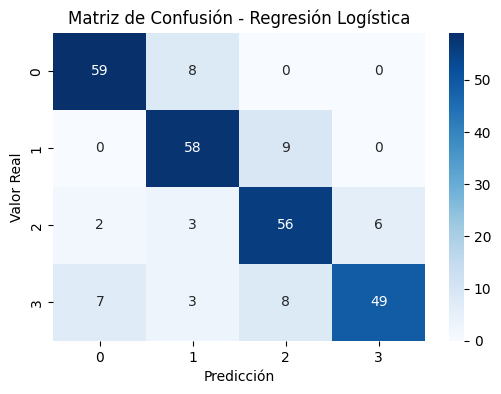


KNN:
Exactitud: 0.7910
Precisión: 0.8058
Recall: 0.7910
F1-Score: 0.7888
Matriz de Confusión:


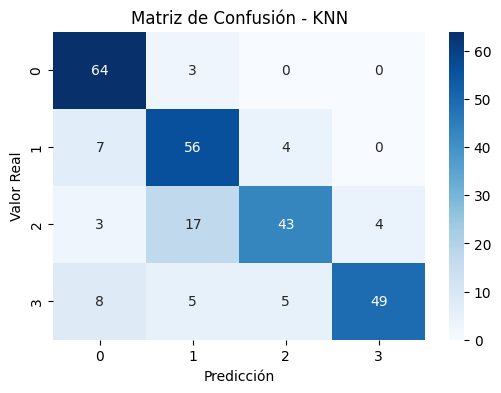


Árbol de Decisión:
Exactitud: 0.8396
Precisión: 0.8499
Recall: 0.8396
F1-Score: 0.8375
Matriz de Confusión:


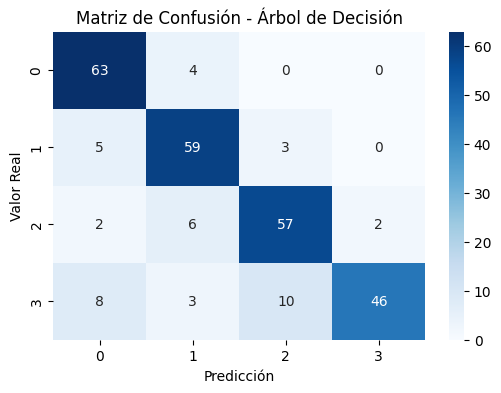


Curvas ROC (Estrategia One-vs-Rest):


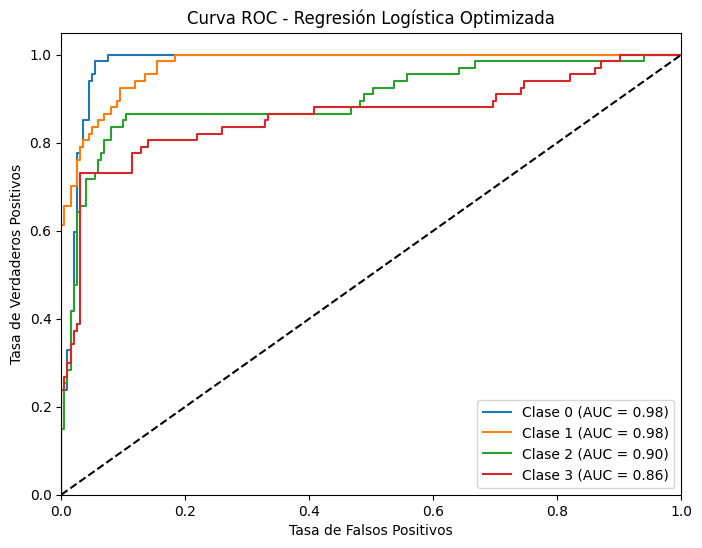

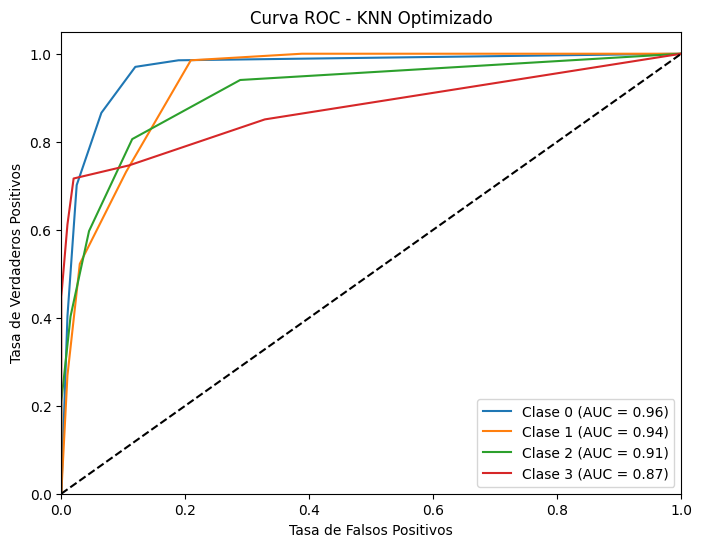

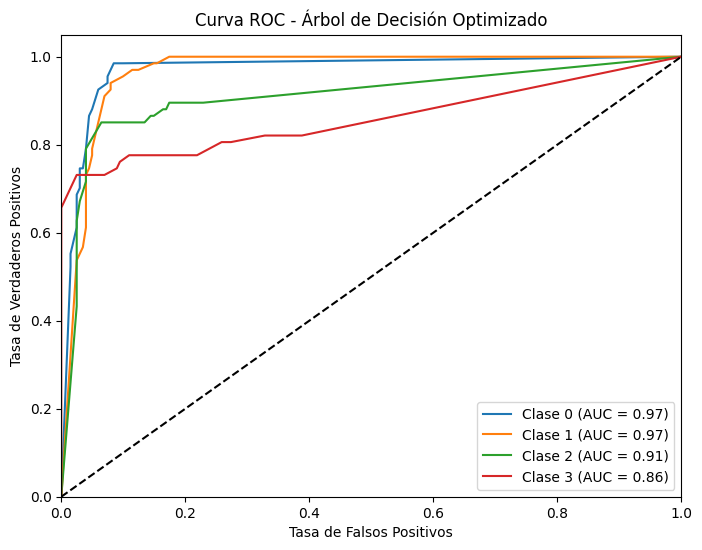

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener los mejores estimadores de los objetos de búsqueda optimizados
best_log_reg = random_search_log_reg.best_estimator_ # Usamos random_search ya que tuvo un rendimiento ligeramente mejor o igual
best_knn = random_search_knn.best_estimator_ # Usamos random_search ya que tuvo un rendimiento igual
best_decision_tree = random_search_decision_tree.best_estimator_ # Usamos random_search ya que tuvo el mejor rendimiento

# Hacer predicciones en el conjunto de prueba con los modelos optimizados
y_pred_log_reg = best_log_reg.predict(X_test)
y_pred_knn = best_knn.predict(X_test)
y_pred_decision_tree = best_decision_tree.predict(X_test)

# Evaluar los modelos optimizados
print("Métricas de Evaluación para Modelos Optimizados:")

# Regresión Logística
print("\nRegresión Logística:")
print(f"Exactitud: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print(f"Precisión: {precision_score(y_test, y_pred_log_reg, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_log_reg, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_log_reg, average='weighted'):.4f}")
print("Matriz de Confusión:")
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Regresión Logística")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()


# KNN
print("\nKNN:")
print(f"Exactitud: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"Precisión: {precision_score(y_test, y_pred_knn, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_knn, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_knn, average='weighted'):.4f}")
print("Matriz de Confusión:")
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - KNN")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()


# Árbol de Decisión
print("\nÁrbol de Decisión:")
print(f"Exactitud: {accuracy_score(y_test, y_pred_decision_tree):.4f}")
print(f"Precisión: {precision_score(y_test, y_pred_decision_tree, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_decision_tree, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_decision_tree, average='weighted'):.4f}")
print("Matriz de Confusión:")
cm_decision_tree = confusion_matrix(y_test, y_pred_decision_tree)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_decision_tree, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Árbol de Decisión")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

# Curvas ROC (para clasificación multiclase, usaremos la estrategia One-vs-Rest)
# Necesitamos las probabilidades predichas para cada clase
try:
    y_prob_log_reg = best_log_reg.predict_proba(X_test)
    y_prob_knn = best_knn.predict_proba(X_test)
    y_prob_decision_tree = best_decision_tree.predict_proba(X_test)

    print("\nCurvas ROC (Estrategia One-vs-Rest):")

    # Función para graficar la curva ROC para clasificación multiclase (One-vs-Rest)
    def plot_multiclass_roc(y_true, y_prob, n_classes, model_name):
        # one-hot encode the true labels
        y_true_one_hot = pd.get_dummies(y_true)

        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_one_hot.iloc[:, i], y_prob[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.title(f'Curva ROC - {model_name}')
        plt.legend(loc="lower right")
        plt.show()

    # Número de clases en la variable objetivo
    n_classes = len(np.unique(y_test))

    # Graficar Curvas ROC
    plot_multiclass_roc(y_test, y_prob_log_reg, n_classes, "Regresión Logística Optimizada")
    plot_multiclass_roc(y_test, y_prob_knn, n_classes, "KNN Optimizado")
    plot_multiclass_roc(y_test, y_prob_decision_tree, n_classes, "Árbol de Decisión Optimizado")

except AttributeError:
    print("\nNota: No todos los modelos tienen el método predict_proba. No se pueden generar las curvas ROC para esos modelos.")

## Conclusiones Finales

Basándonos en la exploración, preprocesamiento, entrenamiento y optimización de los modelos de clasificación (Regresión Logística, KNN y Árbol de Decisión) para predecir la categoría de los costos médicos, podemos extraer las siguientes conclusiones:

1.  **Calidad de los Datos:** El dataset inicial se encontró limpio, sin valores faltantes, lo que simplificó la etapa de preprocesamiento al no requerir imputación.
2.  **Preprocesamiento:** Se realizó un preprocesamiento adecuado, escalando las características numéricas y codificando las categóricas, preparando los datos para los modelos de aprendizaje automático.
3.  **Rendimiento Inicial de los Modelos:** La evaluación inicial con validación cruzada mostró que la Regresión Logística tuvo un rendimiento ligeramente superior al KNN y al Árbol de Decisión sin optimización.
4.  **Optimización de Hiperparámetros:**
    *   Tanto GridSearchCV como RandomizedSearchCV se utilizaron para optimizar los hiperparámetros de los modelos.
    *   En la mayoría de los casos, RandomizedSearchCV encontró hiperparámetros que resultaron en un rendimiento (precisión de validación cruzada) igual o ligeramente mejor que GridSearchCV. Esto sugiere que, para este problema y espacio de hiperparámetros, RandomizedSearchCV fue eficiente explorando combinaciones prometedoras.
    *   El Árbol de Decisión optimizado con RandomizedSearchCV obtuvo la mejor precisión de validación cruzada (0.881) entre los modelos probados y los métodos de optimización.
5.  **Evaluación Final en el Conjunto de Prueba:**
    *   Al evaluar los modelos optimizados en el conjunto de prueba, el **Árbol de Decisión optimizado (con parámetros de RandomizedSearchCV)** continuó mostrando el mejor rendimiento en términos de exactitud (0.8396) y un buen balance entre precisión y recall (F1-Score: 0.8375).
    *   La Regresión Logística optimizada tuvo un rendimiento cercano (Exactitud: 0.8284, F1-Score: 0.8280).
    *   KNN optimizado tuvo el rendimiento más bajo en el conjunto de prueba (Exactitud: 0.7910, F1-Score: 0.7888).
    *   Las matrices de confusión y las curvas ROC proporcionan una visión más detallada del rendimiento de cada modelo por clase, confirmando la capacidad del Árbol de Decisión para clasificar correctamente la mayoría de las instancias.

**En resumen**, el Árbol de Decisión optimizado mediante RandomizedSearchCV demostró ser el modelo más efectivo para esta tarea de clasificación de costos médicos, logrando un buen equilibrio entre la complejidad del modelo y su capacidad predictiva en datos no vistos. RandomizedSearchCV resultó ser un método eficiente para la búsqueda de hiperparámetros en este caso particular.